# Backtesting de Estrategia de Cruce de Medias Móviles para AAPL


C:\Users\apicn\AppData\Local\Temp\ipykernel_33692\1203889923.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2020-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed



Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.620842,72.681289,71.373218,71.627092,135480400
2020-01-03,71.914803,72.676431,71.689942,71.847102,146322800
2020-01-06,72.487846,72.526533,70.783248,71.034709,118387200
2020-01-07,72.146942,72.753823,71.926915,72.497529,108872000
2020-01-08,73.307503,73.609737,71.849525,71.849525,132079200


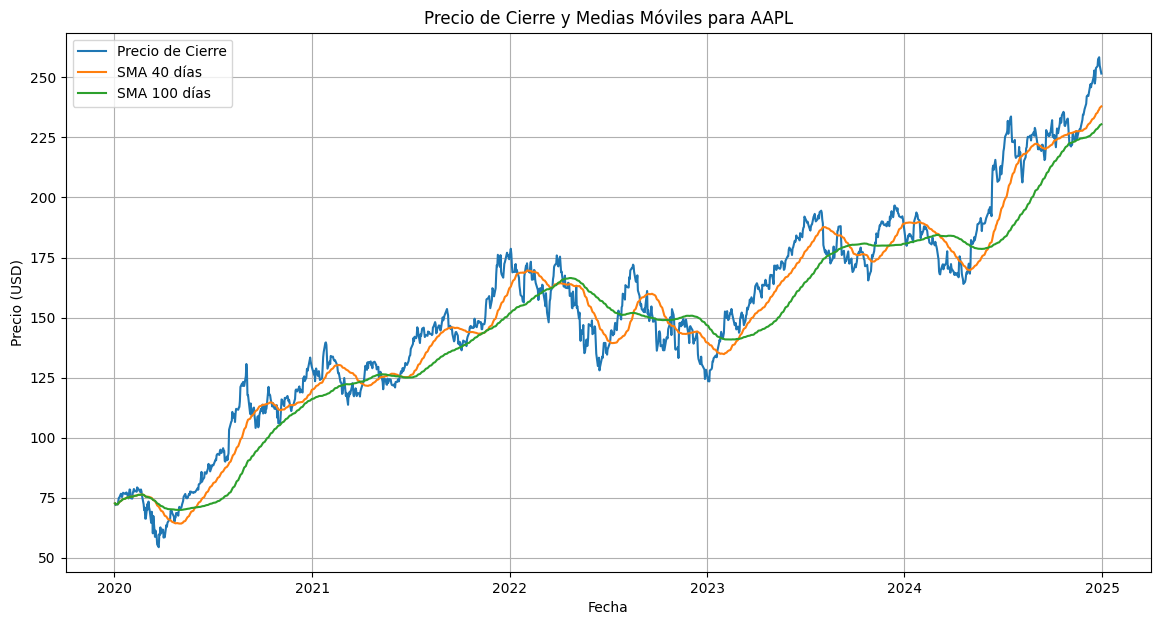

In [21]:
# Importar librerías necesarias
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Descargar datos históricos para Apple (AAPL)
ticker = 'AAPL'
data = yf.download(ticker, start='2020-01-01', end='2024-12-31')

# Verificar que los datos no estén vacíos
display(data.head())
if data.empty:
    raise ValueError('No se descargaron datos para el ticker y rango de fechas seleccionados.')

# Definir los periodos para las medias móviles (parámetros base)
short_window = 40  # Media móvil rápida (ej. 40 días)
long_window = 100  # Media móvil lenta (ej. 100 días)

# Calcular las medias móviles
data['SMA_short'] = data['Close'].rolling(window=short_window, min_periods=1).mean()
data['SMA_long'] = data['Close'].rolling(window=long_window, min_periods=1).mean()

# Visualizar los precios y las medias móviles
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Precio de Cierre')
plt.plot(data['SMA_short'], label=f'SMA {short_window} días')
plt.plot(data['SMA_long'], label=f'SMA {long_window} días')
plt.title('Precio de Cierre y Medias Móviles para AAPL')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Generación de Señales de Trading

En esta sección se generan las señales de compra y venta utilizando el cruce de medias móviles. Cuando la media móvil corta cruza por encima de la larga, se genera una señal de compra; cuando cruza por debajo, una señal de venta.

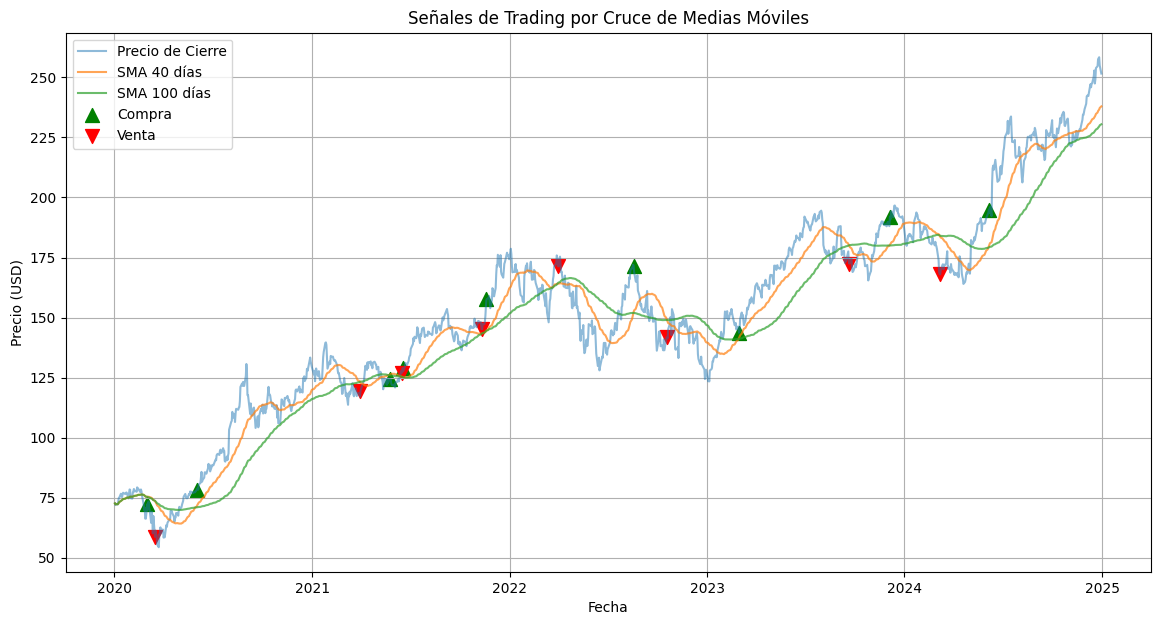

In [22]:
# Generar señales de compra y venta por cruce de medias móviles

data['Signal'] = 0  # 1 para compra, 0 para mantener
# Señal de compra cuando la SMA corta cruza por encima de la larga
# Señal de venta cuando la SMA corta cruza por debajo de la larga

data['Signal'] = np.where(data['SMA_short'] > data['SMA_long'], 1, 0)
data['Position'] = data['Signal'].diff()

# Filtrar las señales de compra y venta reales
buy_signals = data[data['Position'] == 1]
sell_signals = data[data['Position'] == -1]

# Visualización profesional de señales
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Precio de Cierre', alpha=0.5)
plt.plot(data['SMA_short'], label=f'SMA {short_window} días', alpha=0.7)
plt.plot(data['SMA_long'], label=f'SMA {long_window} días', alpha=0.7)
plt.scatter(buy_signals.index, buy_signals['Close'], label='Compra', marker='^', color='green', s=100)
plt.scatter(sell_signals.index, sell_signals['Close'], label='Venta', marker='v', color='red', s=100)
plt.title('Señales de Trading por Cruce de Medias Móviles')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Motor de Backtesting

Simulamos la evolución de un portafolio aplicando las señales generadas. Se parte de un capital inicial y se calcula el valor del portafolio día a día, considerando compras y ventas según las señales.

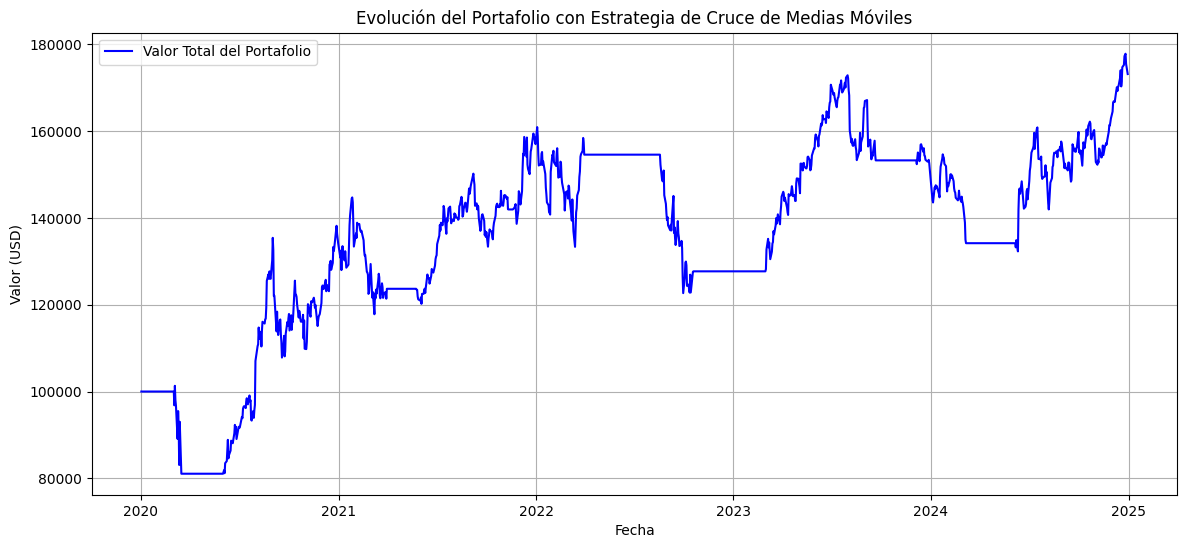

In [23]:
# Simulación del portafolio con las señales generadas
initial_capital = 100000.0
cash = initial_capital
position = 0      # 0: sin posición, 1: en posición
num_shares = 0

portfolio_cash = [initial_capital]
portfolio_holdings = [0.0]
portfolio_total = [initial_capital]
holdings_value = 0.0

for i in range(1, len(data)):
    current_price = data['Close'].iloc[i].item()
    # Compra
    if data['Position'].iloc[i] == 1 and position == 0:
        position = 1
        num_shares = cash / current_price
        holdings_value = num_shares * current_price
        cash = 0
    # Venta
    elif data['Position'].iloc[i] == -1 and position == 1:
        position = 0
        cash += num_shares * current_price
        holdings_value = 0
        num_shares = 0
    # Actualizar valor de tenencia
    if position == 1:
        holdings_value = num_shares * current_price
    else:
        holdings_value = 0
    portfolio_cash.append(cash)
    portfolio_holdings.append(holdings_value)
    portfolio_total.append(cash + holdings_value)

# DataFrame del portafolio
portfolio = pd.DataFrame({
    'cash': portfolio_cash,
    'holdings': portfolio_holdings,
    'total': portfolio_total
}, index=data.index)
portfolio['returns'] = portfolio['total'].pct_change()

# Visualización de la evolución del portafolio
plt.figure(figsize=(14, 6))
plt.plot(portfolio['total'], label='Valor Total del Portafolio', color='blue')
plt.title('Evolución del Portafolio con Estrategia de Cruce de Medias Móviles')
plt.xlabel('Fecha')
plt.ylabel('Valor (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Conclusiones del Backtesting

- La estrategia de cruce de medias móviles permite automatizar decisiones de compra y venta de manera sencilla y replicable.
- El portafolio evoluciona en función de las señales, mostrando el impacto de los parámetros elegidos y la importancia de la gestión cuantitativa.
- Este análisis es una base sólida para explorar optimización de parámetros, gestión de riesgos y comparación con otras estrategias.
- No se han considerado comisiones ni deslizamientos, por lo que los resultados pueden diferir de la operativa real.


# Backtesting Realista: Incluyendo Comisiones y Costos de Transacción

Para acercar el análisis a la realidad, incluimos un costo fijo por operación (compra o venta) y una comisión porcentual sobre el monto transado. Esto permite evaluar el impacto de los costos en la rentabilidad de la estrategia.

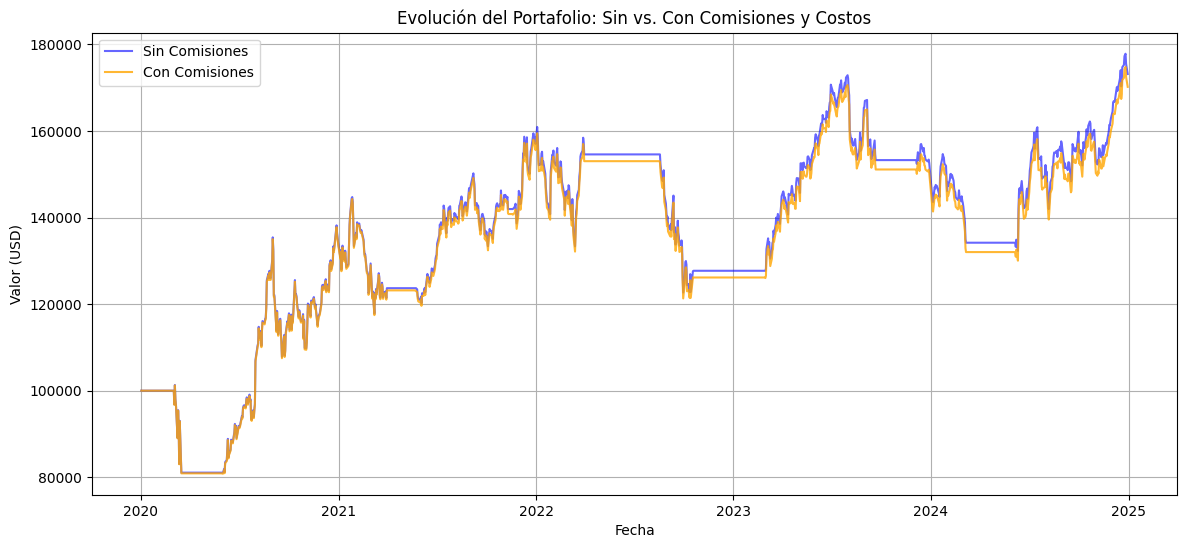

In [24]:
# Simulación con comisiones y costos de transacción
# Parámetros realistas
comision_pct = 0.001  # 0.1% por operación
costo_fijo = 2.0      # $2 por cada compra o venta

cash = initial_capital
position = 0
num_shares = 0
portfolio_cash = [initial_capital]
portfolio_holdings = [0.0]
portfolio_total = [initial_capital]
holdings_value = 0.0

for i in range(1, len(data)):
    current_price = data['Close'].iloc[i].item()
    # Compra
    if data['Position'].iloc[i] == 1 and position == 0:
        monto_compra = cash
        comision = monto_compra * comision_pct + costo_fijo
        efectivo_para_compra = cash - comision
        if efectivo_para_compra > 0:
            position = 1
            num_shares = efectivo_para_compra / current_price
            holdings_value = num_shares * current_price
            cash = 0
        else:
            num_shares = 0
            holdings_value = 0
    # Venta
    elif data['Position'].iloc[i] == -1 and position == 1:
        monto_venta = num_shares * current_price
        comision = monto_venta * comision_pct + costo_fijo
        cash = monto_venta - comision
        position = 0
        holdings_value = 0
        num_shares = 0
    # Actualizar valor de tenencia
    if position == 1:
        holdings_value = num_shares * current_price
    else:
        holdings_value = 0
    portfolio_cash.append(cash)
    portfolio_holdings.append(holdings_value)
    portfolio_total.append(cash + holdings_value)

# DataFrame del portafolio con comisiones
portfolio_realista = pd.DataFrame({
    'cash': portfolio_cash,
    'holdings': portfolio_holdings,
    'total': portfolio_total
}, index=data.index)
portfolio_realista['returns'] = portfolio_realista['total'].pct_change()

# Visualización comparativa
plt.figure(figsize=(14, 6))
plt.plot(portfolio['total'], label='Sin Comisiones', color='blue', alpha=0.6)
plt.plot(portfolio_realista['total'], label='Con Comisiones', color='orange', alpha=0.8)
plt.title('Evolución del Portafolio: Sin vs. Con Comisiones y Costos')
plt.xlabel('Fecha')
plt.ylabel('Valor (USD)')
plt.legend()
plt.grid(True)
plt.show()

# ¿Por qué es importante considerar comisiones y costos de transacción?

**Diferencias clave:**
- Sin comisiones, los resultados del backtesting suelen ser optimistas y no reflejan la realidad del mercado.
- Al incluir comisiones y costos, se observa una reducción en la rentabilidad, especialmente en estrategias con muchas operaciones.
- Ignorar estos costos puede llevar a sobreestimar el desempeño de una estrategia y tomar decisiones poco informadas.

**¿Para qué sirve este análisis?**
- Permite evaluar si una estrategia sigue siendo rentable después de descontar los costos reales de operar.
- Ayuda a comparar estrategias: una menos activa puede ser más rentable neta si los costos son altos.
- Fomenta una visión más profesional y realista del trading cuantitativo.

**Consejos para quienes empiezan a invertir:**
- Siempre considera los costos de transacción antes de operar.
- Comienza con estrategias simples y bien entendidas.
- No te dejes llevar solo por resultados pasados: elige estrategias robustas y diversifica.
- Invierte solo dinero que estés dispuesto a mantener a largo plazo y aprende sobre gestión de riesgos.
- Utiliza el backtesting como herramienta de aprendizaje, pero valida tus ideas en el mercado real con pequeñas cantidades primero.

> Invertir de manera informada y realista es clave para el éxito financiero a largo plazo.